In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10/cifar-100-python/meta
/kaggle/input/cifar10/cifar-100-python/file.txt~
/kaggle/input/cifar10/cifar-100-python/test
/kaggle/input/cifar10/cifar-100-python/train


In [13]:
import os

# The files are already unzipped in the input directory, so we point directly to them.
data_root = "/kaggle/input/cifar10/cifar-100-python"
print("Files in data_root:", os.listdir(data_root))


Files in data_root: ['meta', 'file.txt~', 'test', 'train']


In [14]:
import pickle
import numpy as np
from PIL import Image
import os

# Paths
data_root = "/kaggle/input/cifar10/cifar-100-python"
output_root = "/kaggle/working/cifar100_images"

# Load meta to get class names
print("Loading metadata...")
with open(os.path.join(data_root, 'meta'), 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'fine_label_names']]

print(f"Found {len(class_names)} classes\n")

# Function to extract images
def extract_split(split_name):
    print(f"{'='*50}")
    print(f"Extracting {split_name.upper()} images...")
    print(f"{'='*50}")
    
    with open(os.path.join(data_root, split_name), 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = data[b'fine_labels']
    
    output_dir = os.path.join(output_root, split_name)
    
    for i, (img, label) in enumerate(zip(images, labels)):
        class_folder = os.path.join(output_dir, class_names[label])
        os.makedirs(class_folder, exist_ok=True)
        
        # Save as PNG
        img_pil = Image.fromarray(img)
        img_pil.save(os.path.join(class_folder, f'{i:05d}.png'))
        
        # Progress indicator
        if (i + 1) % 2500 == 0:
            print(f"  Progress: {i+1}/{len(images)} images ({(i+1)/len(images)*100:.1f}%)")
    
    print(f"✓ {split_name.upper()} complete: {len(images)} images saved to {output_dir}\n")
    return len(images)

# Extract both train and test
train_count = extract_split('train')
test_count = extract_split('test')

# Verification
print(f"{'='*50}")
print(f"EXTRACTION SUMMARY")
print(f"{'='*50}")
print(f"Train images: {train_count:,}")
print(f"Test images:  {test_count:,}")
print(f"Total:        {train_count + test_count:,}")
print(f"\nOutput location: {output_root}")

# Verify folder structure
print(f"\nVerifying structure...")
for split in ['train', 'test']:
    split_path = os.path.join(output_root, split)
    if os.path.exists(split_path):
        num_classes = len([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
        print(f"  ✓ {split}: {num_classes} class folders")
    else:
        print(f"  ✗ {split}: NOT FOUND")

print("\n✓ All done! You can now use CIFAR100ImageFolder on both train and test.")


Loading metadata...
Found 100 classes

Extracting TRAIN images...
  Progress: 2500/50000 images (5.0%)
  Progress: 5000/50000 images (10.0%)
  Progress: 7500/50000 images (15.0%)
  Progress: 10000/50000 images (20.0%)
  Progress: 12500/50000 images (25.0%)
  Progress: 15000/50000 images (30.0%)
  Progress: 17500/50000 images (35.0%)
  Progress: 20000/50000 images (40.0%)
  Progress: 22500/50000 images (45.0%)
  Progress: 25000/50000 images (50.0%)
  Progress: 27500/50000 images (55.0%)
  Progress: 30000/50000 images (60.0%)
  Progress: 32500/50000 images (65.0%)
  Progress: 35000/50000 images (70.0%)
  Progress: 37500/50000 images (75.0%)
  Progress: 40000/50000 images (80.0%)
  Progress: 42500/50000 images (85.0%)
  Progress: 45000/50000 images (90.0%)
  Progress: 47500/50000 images (95.0%)
  Progress: 50000/50000 images (100.0%)
✓ TRAIN complete: 50000 images saved to /kaggle/working/cifar100_images/train

Extracting TEST images...
  Progress: 2500/10000 images (25.0%)
  Progress: 50

In [15]:
import os

root_dir = "/kaggle/working/cifar100_images"

# Check how many classes you have
classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
print(f"Number of classes: {len(classes)}")
print(f"First 10 classes: {classes[:10]}")

# Check how many images in 'apple' class
apple_dir = "/kaggle/working/cifar100_images/train/apple"
num_apple_images = len([f for f in os.listdir(apple_dir) if f.endswith('.png')])
print(f"\nNumber of 'apple' images: {num_apple_images}")

# Show a sample image path
sample_image = os.path.join(apple_dir, os.listdir(apple_dir)[0])
print(f"Sample image path: {sample_image}")


Number of classes: 2
First 10 classes: ['test', 'train']

Number of 'apple' images: 500
Sample image path: /kaggle/working/cifar100_images/train/apple/43363.png


In [16]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CIFAR100ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Path to folder containing class subfolders
                      e.g., '/kaggle/working/cifar100_images/train'
            transform: Optional transforms (ToTensor, Normalize, etc.)
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Get sorted list of class folders (ensures consistent label assignment)
        self.classes = sorted([d for d in os.listdir(root_dir) 
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect all image paths and their labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            label = self.class_to_idx[class_name]
            
            for img_filename in os.listdir(class_dir):
                if img_filename.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_filename)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        print(f"Loaded {len(self.image_paths)} images from {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# ✅ CORRECT PATHS - Point to the extracted folders
train_dataset = CIFAR100ImageFolder(
    root_dir='/kaggle/working/cifar100_images/train',  # ← Fixed path
    transform=train_transform
)

test_dataset = CIFAR100ImageFolder(
    root_dir='/kaggle/working/cifar100_images/test',   # ← Fixed path
    transform=test_transform
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")
print(f"✓ Number of classes: {len(train_dataset.classes)}")


Loaded 50000 images from 100 classes
Loaded 10000 images from 100 classes
✓ Train samples: 50000
✓ Test samples: 10000
✓ Number of classes: 100


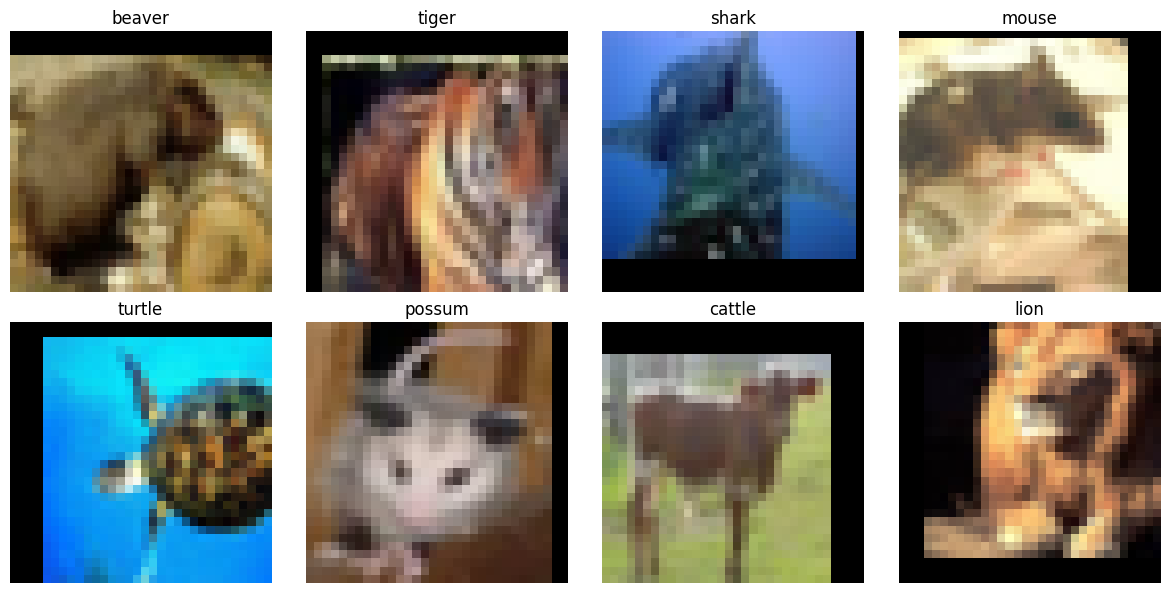

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from the dataloader
images, labels = next(iter(train_loader))

# Denormalize for visualization
def denormalize(img):
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)
    return img * std + mean

# Plot first 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(train_dataset.classes[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [19]:
"""
=============================================================================
FLASH ATTENTION BLOCK IMPLEMENTATION
Integrates PyTorch's scaled_dot_product_attention (Flash Attention) into CNN
=============================================================================
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class FlashAttentionBlock(nn.Module):
    """
    Self-Attention block using PyTorch's Flash Attention kernel
    - Automatically uses fused CUDA kernel on T4 GPUs
    - Memory efficient O(N) vs standard O(N²)
    - 2-4x faster than standard attention
    """
    def __init__(self, channels, num_heads=4):
        super().__init__()
        assert channels % num_heads == 0, f"channels ({channels}) must be divisible by num_heads ({num_heads})"
        
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5
        
        # QKV projection
        self.qkv = nn.Linear(channels, channels * 3)
        self.proj = nn.Linear(channels, channels)
        
        # Layer norm for stability
        self.norm = nn.LayerNorm(channels)
        
    def forward(self, x):
        """
        Args:
            x: (B, C, H, W) - feature maps from CNN
        Returns:
            out: (B, C, H, W) - attention-weighted features
        """
        B, C, H, W = x.shape
        identity = x  # For residual connection
        
        # Reshape: (B, C, H, W) -> (B, H*W, C)
        x = x.permute(0, 2, 3, 1).flatten(1, 2)  # (B, H*W, C)
        x = self.norm(x)
        
        # QKV projection
        qkv = self.qkv(x).reshape(B, H*W, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.unbind(2)  # Each: (B, H*W, num_heads, head_dim)
        
        # Permute for attention: (B, num_heads, H*W, head_dim)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)
        
        # ============================================================
        # FLASH ATTENTION - Uses PyTorch's fused kernel on T4 GPUs
        # Automatically selects optimal implementation
        # ============================================================
        with torch.backends.cuda.sdp_kernel(
            enable_flash=True,      # Enable Flash Attention
            enable_math=False,      # Disable slow fallback
            enable_mem_efficient=True  # Enable memory-efficient variant
        ):
            out = F.scaled_dot_product_attention(q, k, v)
        
        # Reshape back: (B, num_heads, H*W, head_dim) -> (B, H*W, C)
        out = out.permute(0, 2, 1, 3).flatten(2)
        out = self.proj(out)
        
        # Reshape to spatial: (B, H*W, C) -> (B, C, H, W)
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)
        
        # Residual connection
        return out + identity


# Test the Flash Attention block
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Test with typical CIFAR-100 feature map size
    test_input = torch.randn(2, 256, 4, 4).to(device)  # (B, C, H, W)
    
    attention_block = FlashAttentionBlock(channels=256, num_heads=4).to(device)
    
    output = attention_block(test_input)
    
    print(f"✓ Flash Attention Block Test")
    print(f"  Input shape:  {test_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Parameters:   {sum(p.numel() for p in attention_block.parameters()):,}")
    print(f"  Device:       {device}")

✓ Flash Attention Block Test
  Input shape:  torch.Size([2, 256, 4, 4])
  Output shape: torch.Size([2, 256, 4, 4])
  Parameters:   263,680
  Device:       cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Now the model definition will work with Flash Attention
class CIFAR100Net(nn.Module):
    def __init__(self, num_classes=100, use_attention=True):
        super(CIFAR100Net, self).__init__()
        self.use_attention = use_attention
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # ✨ Flash Attention Block
        if self.use_attention:
            self.attention = FlashAttentionBlock(channels=256, num_heads=8)
            print("✓ Flash Attention enabled (8 heads)")
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        
        # Apply Flash Attention if enabled
        if self.use_attention:
            x = self.attention(x)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model with Flash Attention
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CIFAR100Net(num_classes=100, use_attention=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model loaded on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Flash Attention: {'ENABLED' if model.use_attention else 'DISABLED'}")

Model loaded on cuda
Total parameters: 3,294,372


In [21]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    print(f'Epoch {epoch+1}: Val Accuracy: {100.*val_correct/val_total:.2f}%\n')

Epoch [1/25], Step [0/391], Loss: 4.6069, Acc: 0.00%
Epoch [1/25], Step [50/391], Loss: 4.6048, Acc: 1.00%
Epoch [1/25], Step [100/391], Loss: 4.3145, Acc: 1.63%
Epoch [1/25], Step [150/391], Loss: 4.3240, Acc: 2.16%
Epoch [1/25], Step [200/391], Loss: 4.2777, Acc: 2.75%
Epoch [1/25], Step [250/391], Loss: 3.9749, Acc: 3.40%
Epoch [1/25], Step [300/391], Loss: 3.8083, Acc: 3.97%
Epoch [1/25], Step [350/391], Loss: 4.2367, Acc: 4.52%
Epoch 1: Val Accuracy: 11.86%

Epoch [2/25], Step [0/391], Loss: 3.9013, Acc: 5.47%
Epoch [2/25], Step [50/391], Loss: 3.8777, Acc: 10.09%
Epoch [2/25], Step [100/391], Loss: 3.7839, Acc: 10.07%
Epoch [2/25], Step [150/391], Loss: 3.9784, Acc: 10.48%
Epoch [2/25], Step [200/391], Loss: 3.6173, Acc: 10.91%
Epoch [2/25], Step [250/391], Loss: 3.4703, Acc: 11.19%
Epoch [2/25], Step [300/391], Loss: 3.5369, Acc: 11.55%
Epoch [2/25], Step [350/391], Loss: 3.6204, Acc: 11.71%
Epoch 2: Val Accuracy: 18.14%

Epoch [3/25], Step [0/391], Loss: 3.6082, Acc: 13.28%
Epo

Loaded 50000 images from 100 classes
Loaded 10000 images from 100 classes
✓ Train: 50000 samples with augmentation
✓ Test:  10000 samples without augmentation


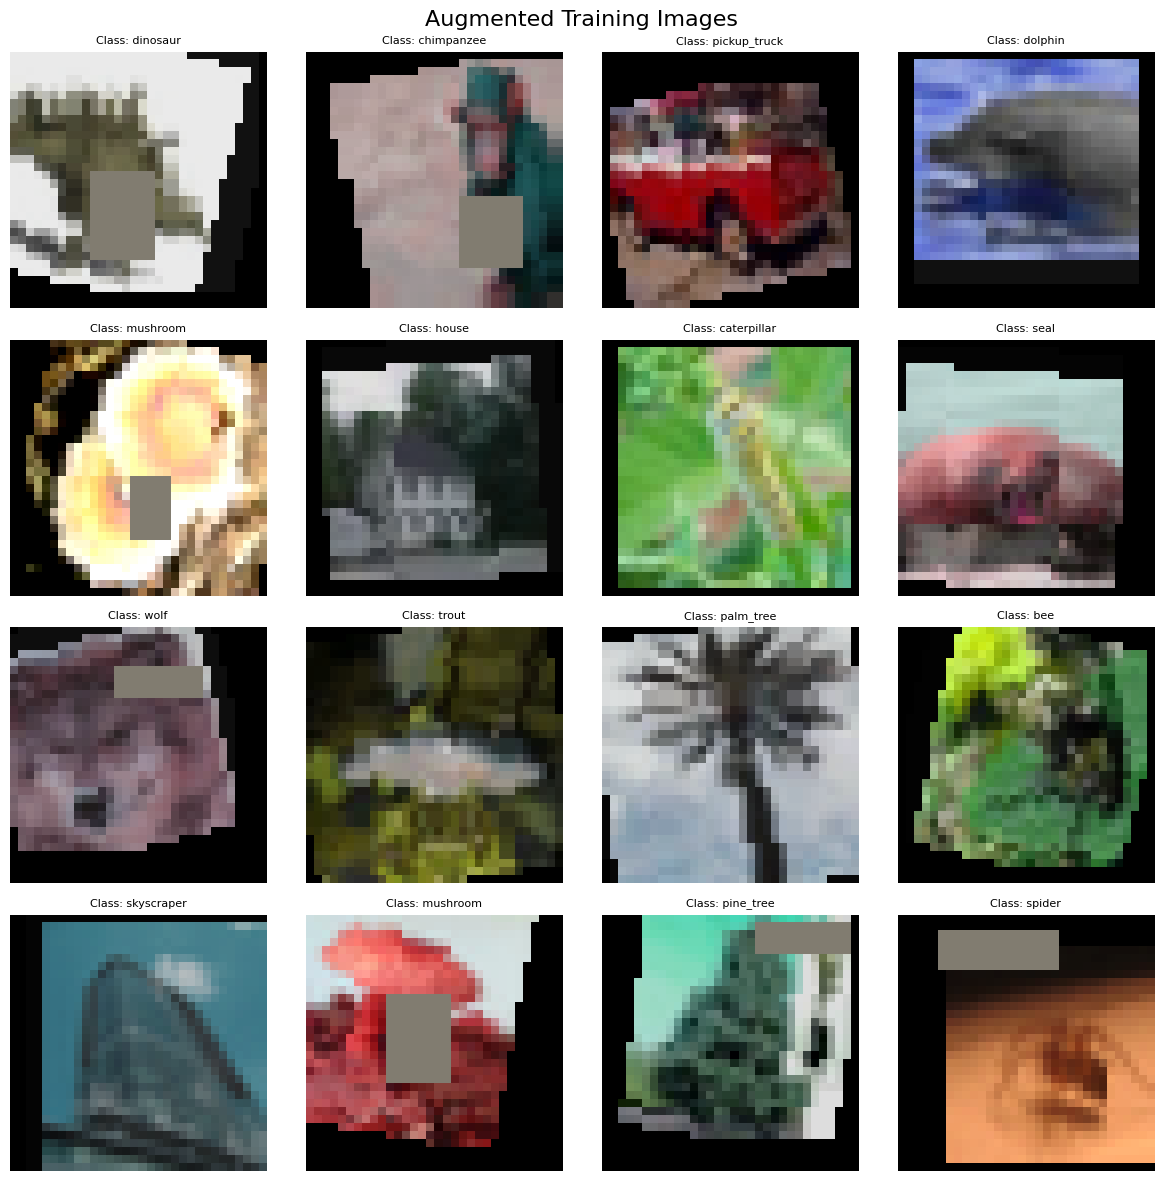

In [22]:
from torchvision import transforms
import torch

# ================== TRAINING AUGMENTATIONS ==================
# Apply heavy augmentation to training data
train_transform = transforms.Compose([
    # 1. Random Crop (crop 32x32 from a 36x36 padded image)
    transforms.RandomCrop(32, padding=4),
    
    # 2. Random Horizontal Flip (50% chance)
    transforms.RandomHorizontalFlip(p=0.5),
    
    # 3. Color Jitter (randomly change brightness, contrast, saturation, hue)
    transforms.ColorJitter(
        brightness=0.2,    # ±20% brightness
        contrast=0.2,      # ±20% contrast
        saturation=0.2,    # ±20% saturation
        hue=0.1            # ±10% hue
    ),
    
    # 4. Random Rotation (±15 degrees)
    transforms.RandomRotation(15),
    
    # 5. Random Affine (slight translations and shearing)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # ±10% shift
        scale=(0.9, 1.1)       # 90%-110% zoom
    ),
    
    # 6. Convert to Tensor
    transforms.ToTensor(),
    
    # 7. Normalize with CIFAR-100 mean and std
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],  # CIFAR-100 channel means
        std=[0.2675, 0.2565, 0.2761]     # CIFAR-100 channel stds
    ),
    
    # 8. Random Erasing (cutout - randomly mask patches)
    transforms.RandomErasing(
        p=0.5,              # 50% chance to apply
        scale=(0.02, 0.1),  # Erase 2%-10% of image
        ratio=(0.3, 3.3)    # Aspect ratio range
    )
])

# ================== TEST/VALIDATION AUGMENTATIONS ==================
# Only normalize for test data (no random augmentations)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

# ================== CREATE DATASETS ==================
train_dataset = CIFAR100ImageFolder(
    root_dir='/kaggle/working/cifar100_images/train',
    transform=train_transform  # Use heavy augmentation
)

test_dataset = CIFAR100ImageFolder(
    root_dir='/kaggle/working/cifar100_images/test',
    transform=test_transform   # No augmentation, just normalize
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"✓ Train: {len(train_dataset)} samples with augmentation")
print(f"✓ Test:  {len(test_dataset)} samples without augmentation")


# Function to denormalize images for visualization
def denormalize(img_tensor):
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)  # Clip to valid range
    return img

# Get one batch of augmented images
images, labels = next(iter(train_loader))

# Plot 16 samples
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Augmented Training Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Denormalize and convert to numpy
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    
    ax.imshow(img)
    ax.set_title(f'Class: {train_dataset.classes[labels[i]]}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
%%writefile training_utils.py
"""
training_utils.py
Production-grade training utilities for PyTorch
"""

import os
import torch
import json
import csv
import shutil
from datetime import datetime
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import numpy as np

# ============================================================================
# DATA SPLITTING
# ============================================================================
class DataSplitter:
    """Handles train/validation splitting with reproducibility"""
    
    @staticmethod
    def split_dataset(dataset, val_ratio=0.1, seed=42):
        val_size = int(len(dataset) * val_ratio)
        train_size = len(dataset) - val_size
        
        train_dataset, val_dataset = random_split(
            dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(seed)
        )
        
        print(f"✓ Split: {train_size:,} train | {val_size:,} validation")
        return train_dataset, val_dataset

# ============================================================================
# CHECKPOINT MANAGEMENT
# ============================================================================
class CheckpointManager:
    def __init__(self, checkpoint_dir='checkpoints', mode='max', metric_name='val_acc'):
        self.checkpoint_dir = checkpoint_dir
        self.mode = mode
        self.metric_name = metric_name
        self.best_metric = float('-inf') if mode == 'max' else float('inf')
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"✓ Checkpoint directory: {checkpoint_dir}")
    
    def is_better(self, current_metric):
        if self.mode == 'max':
            return current_metric > self.best_metric
        else:
            return current_metric < self.best_metric
    
    def save_checkpoint(self, state, epoch, metric_value, save_freq=5):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': state['model'].state_dict(),
            'optimizer_state_dict': state['optimizer'].state_dict(),
            'scheduler_state_dict': state.get('scheduler').state_dict() if state.get('scheduler') else None,
            'best_metric': self.best_metric,
            'current_metric': metric_value,
            'metric_name': self.metric_name
        }
        
        latest_path = os.path.join(self.checkpoint_dir, 'checkpoint_latest.pth')
        torch.save(checkpoint, latest_path)
        
        if self.is_better(metric_value):
            self.best_metric = metric_value
            best_path = os.path.join(self.checkpoint_dir, 'checkpoint_best.pth')
            shutil.copy(latest_path, best_path)
            print(f"  ✓ New best {self.metric_name}: {self.best_metric:.4f}")
            return True
        
        if (epoch + 1) % save_freq == 0:
            periodic_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, periodic_path)
        
        return False
    
    def load_checkpoint(self, model, optimizer=None, scheduler=None, checkpoint_type='latest'):
        if checkpoint_type == 'latest':
            checkpoint_path = os.path.join(self.checkpoint_dir, 'checkpoint_latest.pth')
        elif checkpoint_type == 'best':
            checkpoint_path = os.path.join(self.checkpoint_dir, 'checkpoint_best.pth')
        else:
            checkpoint_path = checkpoint_type
        
        if not os.path.exists(checkpoint_path):
            print(f"  ⚠ No checkpoint found at {checkpoint_path}")
            return 0
        
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if scheduler and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        self.best_metric = checkpoint.get('best_metric', self.best_metric)
        start_epoch = checkpoint['epoch'] + 1
        
        print(f"  ✓ Resumed from epoch {checkpoint['epoch']} | Best {self.metric_name}: {self.best_metric:.4f}")
        return start_epoch

# ============================================================================
# LOGGING
# ============================================================================
class TrainingLogger:
    def __init__(self, log_dir='logs', experiment_name=None):
        if experiment_name is None:
            experiment_name = datetime.now().strftime('run_%Y%m%d_%H%M%S')
        
        self.run_dir = os.path.join(log_dir, experiment_name)
        os.makedirs(self.run_dir, exist_ok=True)
        
        self.writer = SummaryWriter(self.run_dir)
        self.csv_path = os.path.join(self.run_dir, 'metrics.csv')
        self.csv_headers = None
        self.metrics_history = defaultdict(list)
        
        print(f"✓ Logging to: {self.run_dir}")
    
    def log_hyperparameters(self, config):
        config_path = os.path.join(self.run_dir, 'config.json')
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
    
    def log_metrics(self, epoch, metrics_dict):
        for key, value in metrics_dict.items():
            if 'loss' in key.lower():
                self.writer.add_scalar(f'Loss/{key}', value, epoch)
            elif 'acc' in key.lower():
                self.writer.add_scalar(f'Accuracy/{key}', value, epoch)
            elif 'lr' in key.lower():
                self.writer.add_scalar('Learning_Rate', value, epoch)
            else:
                self.writer.add_scalar(f'Metrics/{key}', value, epoch)
        
        if self.csv_headers is None:
            self.csv_headers = ['epoch'] + list(metrics_dict.keys())
            with open(self.csv_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(self.csv_headers)
        
        with open(self.csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            row = [epoch] + [f"{v:.6f}" if isinstance(v, float) else v 
                             for v in metrics_dict.values()]
            writer.writerow(row)
        
        self.metrics_history['epoch'].append(epoch)
        for key, value in metrics_dict.items():
            self.metrics_history[key].append(value)
    
    def close(self):
        self.writer.close()

# ============================================================================
# EARLY STOPPING
# ============================================================================
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
    
    def __call__(self, current_score, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = epoch
            return False
        
        if self.mode == 'max':
            improved = current_score > self.best_score + self.min_delta
        else:
            improved = current_score < self.best_score - self.min_delta
        
        if improved:
            self.best_score = current_score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            print(f"  ⚠ EarlyStopping: {self.counter}/{self.patience}")
            
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"  ✗ Early stopping! Best: {self.best_score:.4f}")
                return True
        
        return False

# ============================================================================
# LR SCHEDULER FACTORY
# ============================================================================
class LRSchedulerFactory:
    @staticmethod
    def create(optimizer, scheduler_type='cosine', **kwargs):
        from torch.optim import lr_scheduler
        
        if scheduler_type == 'cosine':
            T_max = kwargs.get('T_max', 50)
            eta_min = kwargs.get('eta_min', 1e-6)
            return lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        
        elif scheduler_type == 'step':
            step_size = kwargs.get('step_size', 20)
            gamma = kwargs.get('gamma', 0.1)
            return lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        elif scheduler_type == 'plateau':
            mode = kwargs.get('mode', 'max')
            patience = kwargs.get('patience', 5)
            factor = kwargs.get('factor', 0.5)
            return lr_scheduler.ReduceLROnPlateau(
                optimizer, mode=mode, patience=patience, factor=factor
            )
        
        else:
            raise ValueError(f"Unknown scheduler: {scheduler_type}")

# ============================================================================
# METRICS TRACKER
# ============================================================================
class MetricsTracker:
    def __init__(self):
        self.metrics = defaultdict(list)
    
    def update(self, **kwargs):
        for key, value in kwargs.items():
            self.metrics[key].append(value)
    
    def get_best(self, key, mode='max'):
        if not self.metrics[key]:
            return None
        return max(self.metrics[key]) if mode == 'max' else min(self.metrics[key])
    
    def summary(self):
        print("\n" + "="*60)
        print("METRICS SUMMARY")
        print("="*60)
        for key, values in self.metrics.items():
            best = max(values) if 'acc' in key else min(values)
            print(f"{key:20s} | Latest: {values[-1]:.4f} | Best: {best:.4f}")
        print("="*60)

print("✓ training_utils.py created successfully!")


Writing training_utils.py


In [24]:
# Now you can import
from training_utils import (
    CheckpointManager,
    TrainingLogger,
    EarlyStopping,
    LRSchedulerFactory,
    DataSplitter,
    MetricsTracker
)

# Use them
checkpoint_manager = CheckpointManager(checkpoint_dir='checkpoints')
logger = TrainingLogger(log_dir='logs')
early_stopping = EarlyStopping(patience=10)

print("✓ Successfully imported all utilities!")


2025-12-11 13:58:22.447528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765461502.679326      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765461502.741384      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ training_utils.py created successfully!
✓ Checkpoint directory: checkpoints
✓ Logging to: logs/run_20251211_135837
✓ Successfully imported all utilities!


In [25]:
"""
COMPLETE PRODUCTION TRAINING WITH ALL UTILITIES
Run this cell to train with proper checkpointing, logging, and early stopping
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from training_utils import (
    CheckpointManager,
    TrainingLogger,
    EarlyStopping,
    LRSchedulerFactory,
    DataSplitter,
    MetricsTracker
)

# ============================================================================
# CONFIGURATION
# ============================================================================
CONFIG = {
    'num_epochs': 50,
    'batch_size': 128,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
    'val_split': 0.1,
    'scheduler': 'cosine',
    'early_stopping_patience': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

device = torch.device(CONFIG['device'])

# ============================================================================
# DATA PREPARATION (You already have this)
# ============================================================================
# Split training data into train/val
full_train_dataset = CIFAR100ImageFolder(
    root_dir='/kaggle/working/cifar100_images/train',
    transform=None
)

train_dataset, val_dataset = DataSplitter.split_dataset(
    full_train_dataset,
    val_ratio=CONFIG['val_split'],
    seed=42
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                        shuffle=False, num_workers=2, pin_memory=True)

# ============================================================================
# MODEL & OPTIMIZER
# ============================================================================
model = CIFAR100Net(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = LRSchedulerFactory.create(optimizer, 'cosine', T_max=CONFIG['num_epochs'])

# ============================================================================
# TRAINING UTILITIES
# ============================================================================
checkpoint_manager = CheckpointManager(checkpoint_dir='checkpoints', mode='max', metric_name='val_acc')
logger = TrainingLogger(log_dir='logs', experiment_name='cifar100_final')
logger.log_hyperparameters(CONFIG)
early_stopping = EarlyStopping(patience=CONFIG['early_stopping_patience'], mode='max')
metrics_tracker = MetricsTracker()

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return running_loss / total, 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, 100. * correct / total

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================
print("="*80)
print("STARTING PRODUCTION TRAINING")
print("="*80)

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update LR
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log metrics
    metrics = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'lr': current_lr
    }
    logger.log_metrics(epoch, metrics)
    metrics_tracker.update(**metrics)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"LR: {current_lr:.6f}")
    
    # Save checkpoint
    state = {'model': model, 'optimizer': optimizer, 'scheduler': scheduler}
    checkpoint_manager.save_checkpoint(state, epoch, val_acc, save_freq=5)
    
    # Early stopping
    if early_stopping(val_acc, epoch):
        print(f"\n✗ Training stopped early at epoch {epoch+1}")
        break

# ============================================================================
# FINAL EVALUATION
# ============================================================================
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

checkpoint_manager.load_checkpoint(model, checkpoint_type='best')
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\nBest Validation Accuracy: {checkpoint_manager.best_metric:.2f}%")
print(f"Final Test Accuracy:      {test_acc:.2f}%")
print(f"Test Loss:                {test_loss:.4f}")
print("="*80)

logger.close()
metrics_tracker.summary()

print("\n✓ Training complete!")
print(f"✓ Best model saved to: checkpoints/checkpoint_best.pth")
print(f"✓ Logs saved to: logs/")
print(f"✓ TensorBoard: tensorboard --logdir logs")


Loaded 50000 images from 100 classes
✓ Split: 45,000 train | 5,000 validation
✓ Checkpoint directory: checkpoints
✓ Logging to: logs/cifar100_final
STARTING PRODUCTION TRAINING

Epoch 1/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.30it/s]



Train Loss: 4.2963 | Train Acc: 3.51%
Val Loss:   4.0046 | Val Acc:   6.92%
LR: 0.000999
  ✓ New best val_acc: 6.9200

Epoch 2/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.71it/s]



Train Loss: 3.8876 | Train Acc: 9.06%
Val Loss:   3.6296 | Val Acc:   13.12%
LR: 0.000996
  ✓ New best val_acc: 13.1200

Epoch 3/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.72it/s]



Train Loss: 3.5832 | Train Acc: 14.14%
Val Loss:   3.3317 | Val Acc:   19.54%
LR: 0.000991
  ✓ New best val_acc: 19.5400

Epoch 4/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.05it/s]



Train Loss: 3.3651 | Train Acc: 18.12%
Val Loss:   3.1380 | Val Acc:   22.46%
LR: 0.000984
  ✓ New best val_acc: 22.4600

Epoch 5/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.95it/s]



Train Loss: 3.1904 | Train Acc: 21.29%
Val Loss:   2.9805 | Val Acc:   26.04%
LR: 0.000976
  ✓ New best val_acc: 26.0400

Epoch 6/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 33.06it/s]



Train Loss: 3.0579 | Train Acc: 23.73%
Val Loss:   2.8345 | Val Acc:   29.08%
LR: 0.000965
  ✓ New best val_acc: 29.0800

Epoch 7/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.39it/s]



Train Loss: 2.9368 | Train Acc: 25.98%
Val Loss:   2.7057 | Val Acc:   31.10%
LR: 0.000952
  ✓ New best val_acc: 31.1000

Epoch 8/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.07it/s]



Train Loss: 2.8383 | Train Acc: 28.20%
Val Loss:   2.6658 | Val Acc:   32.58%
LR: 0.000938
  ✓ New best val_acc: 32.5800

Epoch 9/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.01it/s]



Train Loss: 2.7462 | Train Acc: 29.86%
Val Loss:   2.5883 | Val Acc:   34.22%
LR: 0.000922
  ✓ New best val_acc: 34.2200

Epoch 10/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.54it/s]



Train Loss: 2.6709 | Train Acc: 31.52%
Val Loss:   2.4920 | Val Acc:   36.04%
LR: 0.000905
  ✓ New best val_acc: 36.0400

Epoch 11/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.71it/s]



Train Loss: 2.5875 | Train Acc: 32.99%
Val Loss:   2.4186 | Val Acc:   37.96%
LR: 0.000885
  ✓ New best val_acc: 37.9600

Epoch 12/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.33it/s]



Train Loss: 2.5213 | Train Acc: 34.32%
Val Loss:   2.3809 | Val Acc:   37.58%
LR: 0.000865
  ⚠ EarlyStopping: 1/15

Epoch 13/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 30.94it/s]



Train Loss: 2.4554 | Train Acc: 35.74%
Val Loss:   2.3100 | Val Acc:   40.54%
LR: 0.000842
  ✓ New best val_acc: 40.5400

Epoch 14/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.40it/s]



Train Loss: 2.4045 | Train Acc: 36.55%
Val Loss:   2.2696 | Val Acc:   41.50%
LR: 0.000819
  ✓ New best val_acc: 41.5000

Epoch 15/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.78it/s]



Train Loss: 2.3425 | Train Acc: 38.06%
Val Loss:   2.2292 | Val Acc:   42.52%
LR: 0.000794
  ✓ New best val_acc: 42.5200

Epoch 16/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.43it/s]



Train Loss: 2.2933 | Train Acc: 39.11%
Val Loss:   2.1866 | Val Acc:   42.64%
LR: 0.000768
  ✓ New best val_acc: 42.6400

Epoch 17/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.74it/s]



Train Loss: 2.2550 | Train Acc: 40.13%
Val Loss:   2.1210 | Val Acc:   44.04%
LR: 0.000741
  ✓ New best val_acc: 44.0400

Epoch 18/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.53it/s]



Train Loss: 2.2002 | Train Acc: 41.00%
Val Loss:   2.1125 | Val Acc:   44.00%
LR: 0.000713
  ⚠ EarlyStopping: 1/15

Epoch 19/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.80it/s]



Train Loss: 2.1585 | Train Acc: 41.96%
Val Loss:   2.0952 | Val Acc:   44.52%
LR: 0.000684
  ✓ New best val_acc: 44.5200

Epoch 20/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.25it/s]



Train Loss: 2.1120 | Train Acc: 43.04%
Val Loss:   2.1162 | Val Acc:   44.14%
LR: 0.000655
  ⚠ EarlyStopping: 1/15

Epoch 21/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.19it/s]



Train Loss: 2.0699 | Train Acc: 44.20%
Val Loss:   2.0533 | Val Acc:   45.84%
LR: 0.000625
  ✓ New best val_acc: 45.8400

Epoch 22/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 29.30it/s]



Train Loss: 2.0214 | Train Acc: 44.91%
Val Loss:   2.0482 | Val Acc:   45.48%
LR: 0.000594
  ⚠ EarlyStopping: 1/15

Epoch 23/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.74it/s]



Train Loss: 1.9921 | Train Acc: 45.78%
Val Loss:   2.0117 | Val Acc:   46.94%
LR: 0.000563
  ✓ New best val_acc: 46.9400

Epoch 24/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.46it/s]



Train Loss: 1.9403 | Train Acc: 46.83%
Val Loss:   1.9937 | Val Acc:   46.76%
LR: 0.000532
  ⚠ EarlyStopping: 1/15

Epoch 25/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.22it/s]



Train Loss: 1.9096 | Train Acc: 47.48%
Val Loss:   1.9569 | Val Acc:   48.36%
LR: 0.000500
  ✓ New best val_acc: 48.3600

Epoch 26/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.14it/s]



Train Loss: 1.8834 | Train Acc: 47.91%
Val Loss:   1.9328 | Val Acc:   49.34%
LR: 0.000469
  ✓ New best val_acc: 49.3400

Epoch 27/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.03it/s]



Train Loss: 1.8486 | Train Acc: 49.00%
Val Loss:   1.9259 | Val Acc:   48.70%
LR: 0.000438
  ⚠ EarlyStopping: 1/15

Epoch 28/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.41it/s]



Train Loss: 1.8069 | Train Acc: 49.70%
Val Loss:   1.9410 | Val Acc:   48.56%
LR: 0.000407
  ⚠ EarlyStopping: 2/15

Epoch 29/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.61it/s]



Train Loss: 1.7649 | Train Acc: 50.83%
Val Loss:   1.9007 | Val Acc:   49.26%
LR: 0.000376
  ⚠ EarlyStopping: 3/15

Epoch 30/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.75it/s]



Train Loss: 1.7350 | Train Acc: 51.55%
Val Loss:   1.8799 | Val Acc:   49.94%
LR: 0.000346
  ✓ New best val_acc: 49.9400

Epoch 31/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.81it/s]



Train Loss: 1.7065 | Train Acc: 51.90%
Val Loss:   1.8761 | Val Acc:   50.08%
LR: 0.000317
  ✓ New best val_acc: 50.0800

Epoch 32/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.80it/s]



Train Loss: 1.6725 | Train Acc: 53.08%
Val Loss:   1.8799 | Val Acc:   49.88%
LR: 0.000288
  ⚠ EarlyStopping: 1/15

Epoch 33/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 30.76it/s]



Train Loss: 1.6408 | Train Acc: 53.75%
Val Loss:   1.8475 | Val Acc:   50.98%
LR: 0.000260
  ✓ New best val_acc: 50.9800

Epoch 34/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.31it/s]



Train Loss: 1.6059 | Train Acc: 54.58%
Val Loss:   1.8424 | Val Acc:   50.62%
LR: 0.000233
  ⚠ EarlyStopping: 1/15

Epoch 35/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.56it/s]



Train Loss: 1.5890 | Train Acc: 55.00%
Val Loss:   1.8363 | Val Acc:   51.00%
LR: 0.000207
  ✓ New best val_acc: 51.0000

Epoch 36/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.00it/s]



Train Loss: 1.5554 | Train Acc: 55.73%
Val Loss:   1.8332 | Val Acc:   51.04%
LR: 0.000182
  ✓ New best val_acc: 51.0400

Epoch 37/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.91it/s]



Train Loss: 1.5230 | Train Acc: 56.62%
Val Loss:   1.8230 | Val Acc:   51.30%
LR: 0.000159
  ✓ New best val_acc: 51.3000

Epoch 38/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.99it/s]



Train Loss: 1.5043 | Train Acc: 56.98%
Val Loss:   1.8236 | Val Acc:   51.22%
LR: 0.000136
  ⚠ EarlyStopping: 1/15

Epoch 39/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.33it/s]



Train Loss: 1.4902 | Train Acc: 57.80%
Val Loss:   1.8181 | Val Acc:   51.32%
LR: 0.000116
  ✓ New best val_acc: 51.3200

Epoch 40/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 30.33it/s]



Train Loss: 1.4633 | Train Acc: 58.00%
Val Loss:   1.8059 | Val Acc:   52.34%
LR: 0.000096
  ✓ New best val_acc: 52.3400

Epoch 41/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.70it/s]



Train Loss: 1.4451 | Train Acc: 58.48%
Val Loss:   1.7994 | Val Acc:   52.14%
LR: 0.000079
  ⚠ EarlyStopping: 1/15

Epoch 42/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.03it/s]



Train Loss: 1.4258 | Train Acc: 59.02%
Val Loss:   1.7989 | Val Acc:   51.78%
LR: 0.000063
  ⚠ EarlyStopping: 2/15

Epoch 43/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 30.59it/s]



Train Loss: 1.4130 | Train Acc: 59.16%
Val Loss:   1.7975 | Val Acc:   52.26%
LR: 0.000049
  ⚠ EarlyStopping: 3/15

Epoch 44/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.45it/s]



Train Loss: 1.4051 | Train Acc: 59.28%
Val Loss:   1.7908 | Val Acc:   52.20%
LR: 0.000036
  ⚠ EarlyStopping: 4/15

Epoch 45/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.15it/s]



Train Loss: 1.3972 | Train Acc: 59.48%
Val Loss:   1.7911 | Val Acc:   52.58%
LR: 0.000025
  ✓ New best val_acc: 52.5800

Epoch 46/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.77it/s]



Train Loss: 1.3851 | Train Acc: 60.04%
Val Loss:   1.7889 | Val Acc:   52.36%
LR: 0.000017
  ⚠ EarlyStopping: 1/15

Epoch 47/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 32.28it/s]



Train Loss: 1.3823 | Train Acc: 60.34%
Val Loss:   1.7890 | Val Acc:   52.30%
LR: 0.000010
  ⚠ EarlyStopping: 2/15

Epoch 48/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.82it/s]



Train Loss: 1.3734 | Train Acc: 60.06%
Val Loss:   1.7873 | Val Acc:   52.42%
LR: 0.000005
  ⚠ EarlyStopping: 3/15

Epoch 49/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.35it/s]



Train Loss: 1.3796 | Train Acc: 60.08%
Val Loss:   1.7869 | Val Acc:   52.46%
LR: 0.000002
  ⚠ EarlyStopping: 4/15

Epoch 50/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 40/40 [00:01<00:00, 31.78it/s]



Train Loss: 1.3726 | Train Acc: 60.28%
Val Loss:   1.7866 | Val Acc:   52.54%
LR: 0.000001
  ⚠ EarlyStopping: 5/15

FINAL EVALUATION ON TEST SET
  ✓ Resumed from epoch 44 | Best val_acc: 52.3400


Validating: 100%|██████████| 79/79 [00:02<00:00, 32.15it/s]


Best Validation Accuracy: 52.34%
Final Test Accuracy:      52.44%
Test Loss:                1.7637

METRICS SUMMARY
train_loss           | Latest: 1.3726 | Best: 1.3726
train_acc            | Latest: 60.2844 | Best: 60.3356
val_loss             | Latest: 1.7866 | Best: 1.7866
val_acc              | Latest: 52.5400 | Best: 52.5800
lr                   | Latest: 0.0000 | Best: 0.0000

✓ Training complete!
✓ Best model saved to: checkpoints/checkpoint_best.pth
✓ Logs saved to: logs/
✓ TensorBoard: tensorboard --logdir logs


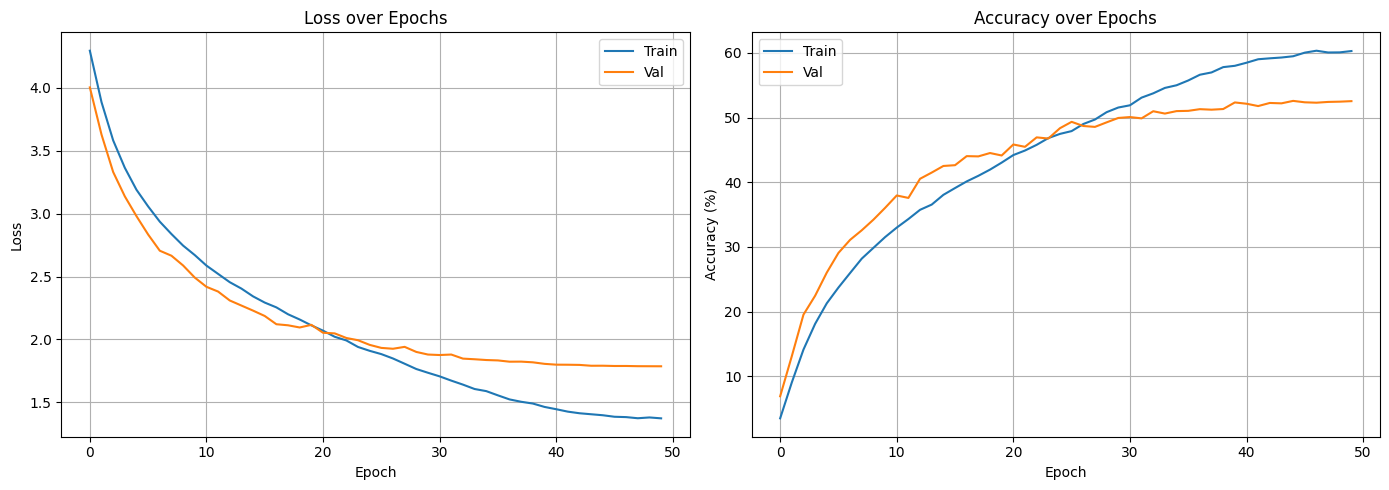

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics
metrics_df = pd.read_csv('logs/cifar100_final/metrics.csv')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train')
axes[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(metrics_df['epoch'], metrics_df['train_acc'], label='Train')
axes[1].plot(metrics_df['epoch'], metrics_df['val_acc'], label='Val')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150)
plt.show()